# Setting up

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import string
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import StepLR
from IPython.display import FileLink
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/MultiLanguageTrainDataset.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/MangolianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/IrishTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/HindiTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/PersianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/UrduTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/GeorgianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/TestEmbedded2/MangolianLASERWordEmbeddings.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/TestEmbedded2/IrishLASERWordEmbeddings.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/TestEmbedded2/GeorgianLASERWordEmbe

In [3]:
preprocessed_trainset = pd.read_pickle('/kaggle/input/translation/other/translation/1/preprocessed_translation_trainset.pkl')
preprocessed_valset = pd.read_pickle('/kaggle/input/translation/other/translation/1/preprocessed_translation_val_set.pkl')
preprocessed_testset = pd.read_pickle('/kaggle/input/translation/other/translation/1/preprocessed_translation_testset.pkl')

# Word2vec Embedding

In [4]:
from gensim.models import Word2Vec
def train_word2vec_model(dataframe):
    """
    Train a Word2Vec model on sentences from the provided DataFrame and apply the model
    to get embeddings for each sentence.
    """
    
    tokenized_sentences = dataframe['cleaned_text'].tolist()

    # Train the Word2Vec model
    word2vec_model = Word2Vec(tokenized_sentences, vector_size=300, window=5, min_count=1, workers=4)

    return word2vec_model

  
# Define a function to get the vector for a list of tokens or return zeros if not found
def get_word_vectors(word2vec_model, tokens):
    vocabulary = word2vec_model.wv.index_to_key
    return np.array([word2vec_model.wv[word] if word in vocabulary else [0] * word2vec_model.vector_size for word in tokens])

In [5]:
def word_embeddings(dataframe, model):

    dataframe['embeddings'] = dataframe['cleaned_text'].apply(lambda x: get_word_vectors(model, x))
    
    return dataframe

## Embedded Trainset

In [6]:
embedding_model = train_word2vec_model(preprocessed_trainset)
embedded_trainset = word_embeddings(preprocessed_trainset, embedding_model)
embedded_trainset

,text,label,cleaned_text,embeddings
39082,RT @Nidalgazaui: This 3 #Russian Soldiers were...,1.0,"[russian, soldier, reportedly, kill, isi, near...","[[-0.8532792, 0.3122053, 0.42994437, -0.082768..."
218612,This news makes me regret it.,0.0,"[news, make, regret]","[[-0.49531016, 0.68727946, -0.07079325, -0.106..."
209310,"USER Only camels &amp; those ""fools who still ...",1.0,"[camel, amp, fool, still, love, order, pig]","[[-0.017049024, 0.5156302, 0.14162153, 0.04510..."
12169,Americans doesnt wanna send soldiers to fight ...,0.0,"[american, doesnt, wan, na, send, soldier, fig...","[[-0.20622829, 0.32496047, 0.11149085, 0.01056..."
214503,"If you use Chinese, put the text content in Ma...",0.0,"[use, chinese, put, text, content, malay, ndon...","[[-0.1038699, 0.568754, 0.07232972, 0.18835667..."
...,...,...,...,...
10426,#WilayatArRaqqah #Photo #Report 3: #Duties of ...,1.0,"[wilayatarraqqah, photo, report, duty, agricul...","[[-0.062216185, 0.04445593, 0.03319673, -0.025..."
212650,The mob that joined the Indonesian Crazy Party...,1.0,"[mob, join, indonesian, crazy, party, psi, mos...","[[0.0020089305, 0.056197055, 0.028712194, 0.04..."
58882,It is absolutely impossible to say that this m...,0.0,"[absolutely, impossible, say, matter, capital,...","[[0.08972346, 0.030528385, -0.017423518, 0.171..."
5021,#News Islamic State rapidly losing ground in I...,0.0,"[news, islamic, state, rapidly, lose, ground, ...","[[-0.49531016, 0.68727946, -0.07079325, -0.106..."


## Embedded Validation Set

In [7]:
embedded_valset = word_embeddings(preprocessed_valset, embedding_model)
embedded_valset

,text,label,cleaned_text,embeddings
211887,"It turns out that after watching the video ""Bi...",1.0,"[turn, watch, video, bigfloo, time, high, top,...","[[0.2622498869895935, 0.22429226338863373, 0.0..."
31334,Number of Today's #Bagdad Bombing on shiite Di...,1.0,"[number, today, bagdad, bomb, shiite, district...","[[-0.30451748, 0.2543279, 0.13961856, 0.413043..."
9832,"Meet Sergei Chupov, the 6th #Russia|n soldier ...",1.0,"[meet, sergei, chupov, th, russian, soldier, r...","[[-0.19829883, 0.36963952, 0.21686044, 0.28235..."
60706,"If you want to find a feminist man, thank you ...",1.0,"[want, find, feminist, man, thank, way, wait, ...","[[-0.28763416, 0.7205231, 0.5680848, 0.7416460..."
54138,@BaxtiyarGoran Will be interesting to see how ...,0.0,"[interest, see, expert, plan, attack, attack, ...","[[0.3989017605781555, -0.07632118463516235, -0..."
...,...,...,...,...
5057,# ...,0.0,[isi],"[[-0.8363221, 0.55898756, 0.13420784, 0.007255..."
62890,"If they could understand these words, would th...",1.0,"[could, understand, word, would, still, go, box]","[[-0.41162035, 0.31468183, 0.31494942, 0.37035..."
63898,"It's great to have a peaceful career, but bein...",1.0,"[great, peaceful, career, rich, man, mean, not...","[[0.046972424, 0.010983448, 0.036846947, 0.847..."
212469,Myanmar Buddhist terrorists opened fire on a b...,0.0,"[myanmar, buddhist, terrorist, open, fire, boa...","[[-0.06879565, 0.110066056, 0.08965644, -0.030..."


## Embedded Testset

In [8]:
embedded_testset = word_embeddings(preprocessed_testset, embedding_model)
embedded_testset

,text,label,cleaned_text,embeddings
141059,RT @warreports: 8 Pakistanis of #IRGC 's Zeyna...,1.0,"[pakistani, irgc, zeynabiun, brigade, kill, no...","[[-0.053269125521183014, 0.1146082729101181, 0..."
6108,gronk tide pod commercial retarded,1.0,"[gronk, tide, pod, commercial, retard]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
108845,@sfrantzman @pmakela1 what they found in Syria...,0.0,"[find, syria, lot, weapon, wwii, gun, shop, is...","[[0.03504086658358574, 0.0971684530377388, -0...."
126712,After Pakistani Taliban announcement of their ...,0.0,"[pakistani, taliban, announcement, support, is...","[[-0.053269125521183014, 0.1146082729101181, 0..."
127530,Good luck getting our attention this week ISIS...,0.0,"[good, luck, get, attention, week, isi, pokemo...","[[0.3063176, 0.05925553, -0.325904, 1.1053603,..."
...,...,...,...,...
242973,There are many other issues that apply to Musl...,0.0,"[many, issue, apply, muslim, lgbt, say, person...","[[0.3457877039909363, -0.4347287714481354, -0...."
232643,"Teach Muslims, religion does not teach killing...",1.0,"[teach, muslims, religion, teach, kill, unders...","[[-0.03942234, 0.048578817, 0.022429872, 0.401..."
234679,"Bismillah,; superiorPRINTING;; Price; Retail :...",0.0,"[bismillah, superiorprinting, price, retail, l...","[[-0.017479093745350838, 0.08399935066699982, ..."
243574,Full Name : Iris Jung\n\nReal Name : Jung An R...,0.0,"[full, name, iris, jungnnreal, name, jung, rin...","[[0.12569302320480347, 0.33570969104766846, -0..."


# Training BiLSTM


#### Batch the data

In [9]:
class EmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe[dataframe['embeddings'].str.len() > 0]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        embeddings = [torch.tensor(np.array(e, dtype=np.float32)) for e in row['embeddings'] if len(e) > 0]
        embeddings = torch.stack(embeddings) if embeddings else torch.empty((0, len(row['embeddings'][0])))
        label = torch.tensor(row['label'], dtype=torch.float32)
        return embeddings, label

In [10]:
def create_tensor_dataset(dataframe):
    """
    Converts a DataFrame with embeddings and labels into a PyTorch TensorDataset.
    """
    # Filter the DataFrame to ensure only valid entries are processed
    valid_entries = dataframe[dataframe['embeddings'].str.len() > 0]
    
    # Create a custom dataset from the filtered DataFrame
    custom_dataset = EmbeddingDataset(valid_entries)
    
    # Collect all embeddings and labels
    embeddings_list = []
    labels_list = []
    
    for embeddings, label in custom_dataset:
        embeddings_list.append(embeddings)
        labels_list.append(label)
    
    # Pad the embeddings to have uniform length
    embeddings_tensor = pad_sequence(embeddings_list, batch_first=True, padding_value=0.0)
    
    # Stack labels into a tensor
    labels_tensor = torch.stack(labels_list)
    
    # Create and return a TensorDataset
    final_dataset = TensorDataset(embeddings_tensor, labels_tensor)
    
    return final_dataset

In [11]:
training_dataset = create_tensor_dataset(embedded_trainset)
validation_dataset = create_tensor_dataset(embedded_valset)
testing_dataset = create_tensor_dataset(embedded_testset)

In [12]:
# en_dataset_train = create_tensor_dataset(embedded_trainset[embedded_trainset.language==3])

In [13]:
# # Calculate the lengths of each subset
# total_size = len(en_dataset_train)
# train_size = int(0.6 * total_size)
# val_size = int(0.3 * total_size)
# test_size = total_size - train_size - val_size  # Ensure all data is used

# # Split the dataset
# training_dataset, validation_dataset, testing_dataset = random_split(en_dataset_train, [train_size, val_size, test_size])

In [14]:
batch_size = 64
# Define batch size for loaders
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False) 

In [15]:
# class SimpleBiLSTM(nn.Module):
#     def __init__(self, embedding_dim, hidden_dim,num_layers,batch_first,bidirectional):
#         super(SimpleBiLSTM, self).__init__()
#         # Define a bidirectional LSTM
#         self.lstm = nn.LSTM(input_size=embedding_dim, 
#                             hidden_size=hidden_dim, 
#                             num_layers=num_layers,
#                             batch_first=batch_first, 
#                             bidirectional=bidirectional)
        
#         # Define a fully connected layer to map the concatenated hidden states to a single output
#         self.fc = nn.Linear(in_features=2 * hidden_dim, out_features=1)

#     def forward(self, x):
#         # Forward pass through LSTM layer
#         _, (hn, _) = self.lstm(x)  # hn contains the hidden state for each direction of each layer
        
#         # Concatenate the last hidden states of the forward and backward passes from the last layer
#         hn_cat = torch.cat((hn[-2], hn[-1]), dim=1)

#         # Pass the concatenated hidden states through the fully connected layer and apply sigmoid activation
#         out = self.fc(hn_cat)
#         out = torch.sigmoid(out)

#         # Squeeze the output to remove the singleton dimension to match expected output shape (batch_size,)
#         return out.squeeze(1)

In [16]:
class SimpleBiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, batch_first, bidirectional, dropout_rate=0.5):
        super(SimpleBiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=embedding_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers,
                            batch_first=batch_first, 
                            bidirectional=bidirectional,
                            dropout=dropout_rate if num_layers > 1 else 0)  # Apply dropout only if there are multiple layers
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(in_features=2 * hidden_dim, out_features=1)

    def forward(self, x):

        _, (hn, _) = self.lstm(x) 
        
        hn_cat = torch.cat((hn[-2], hn[-1]), dim=1)

        hn_cat = self.dropout(hn_cat)

        out = self.fc(hn_cat)
        out = torch.sigmoid(out)

        return out.squeeze(1)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming model instantiation and optimizer setup as before
model = SimpleBiLSTM(embedding_dim=300, hidden_dim=128, num_layers=2, batch_first=True, bidirectional=True)
num_epochs = 15
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
patience = 2
delta = 0.001

# Print the summary of the model
summary(model, input_size=(64, 256, 300))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleBiLSTM                             [64]                      --
├─LSTM: 1-1                              [64, 256, 256]            835,584
├─Dropout: 1-2                           [64, 256]                 --
├─Linear: 1-3                            [64, 1]                   257
Total params: 835,841
Trainable params: 835,841
Non-trainable params: 0
Total mult-adds (G): 13.69
Input size (MB): 19.66
Forward/backward pass size (MB): 33.55
Params size (MB): 3.34
Estimated Total Size (MB): 56.56

In [18]:
def validate_model(model, epoch, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Val)'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, device, patience, delta, save_path):
    
    model.to(device)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    early_stopping_counter = 0  # Initialize the counter for early stopping

    for epoch in range(num_epochs):
        model.train()
        total_loss, total, correct = 0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_avg_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_avg_loss)
        train_accuracies.append(train_accuracy)

        val_avg_loss, val_accuracy = validate_model(model, epoch, val_loader, criterion, device)
        val_losses.append(val_avg_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'End of Epoch {epoch+1}, Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        
        if val_avg_loss < best_val_loss - delta:
            best_val_loss = val_avg_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f'Model saved: Epoch {epoch+1} with Val Loss: {val_avg_loss:.4f}')
        else:
            early_stopping_counter += 1
            print(f'No improvement in Val Loss for {early_stopping_counter} epoch(s)')

        if early_stopping_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

        scheduler.step()

    return train_losses, train_accuracies, val_losses, val_accuracies

In [20]:
# Assume you have run your training function already
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, device, patience, delta, save_path='BiLSTM_translate.pth')

Epoch 1/15 (Val): 100%|██████████| 428/428 [00:06<00:00, 66.69it/s]


End of Epoch 1, Train Loss: 0.4661, Train Accuracy: 77.20%, Val Loss: 0.4124, Val Accuracy: 80.60%
Model saved: Epoch 1 with Val Loss: 0.4124


Epoch 2/15 (Val): 100%|██████████| 428/428 [00:06<00:00, 67.24it/s]


End of Epoch 2, Train Loss: 0.4081, Train Accuracy: 80.93%, Val Loss: 0.3965, Val Accuracy: 81.44%
Model saved: Epoch 2 with Val Loss: 0.3965


Epoch 3/15 (Val): 100%|██████████| 428/428 [00:06<00:00, 67.63it/s]


End of Epoch 3, Train Loss: 0.3869, Train Accuracy: 82.25%, Val Loss: 0.3832, Val Accuracy: 82.27%
Model saved: Epoch 3 with Val Loss: 0.3832


Epoch 4/15 (Val): 100%|██████████| 428/428 [00:06<00:00, 66.87it/s]


End of Epoch 4, Train Loss: 0.3718, Train Accuracy: 82.91%, Val Loss: 0.3773, Val Accuracy: 82.38%
Model saved: Epoch 4 with Val Loss: 0.3773


Epoch 5/15 (Val): 100%|██████████| 428/428 [00:06<00:00, 66.25it/s]


End of Epoch 5, Train Loss: 0.3626, Train Accuracy: 83.37%, Val Loss: 0.3641, Val Accuracy: 83.51%
Model saved: Epoch 5 with Val Loss: 0.3641


Epoch 6/15 (Val): 100%|██████████| 428/428 [00:06<00:00, 67.44it/s]


End of Epoch 6, Train Loss: 0.3348, Train Accuracy: 84.85%, Val Loss: 0.3534, Val Accuracy: 84.12%
Model saved: Epoch 6 with Val Loss: 0.3534


Epoch 7/15 (Val): 100%|██████████| 428/428 [00:06<00:00, 67.45it/s]


End of Epoch 7, Train Loss: 0.3263, Train Accuracy: 85.36%, Val Loss: 0.3506, Val Accuracy: 84.15%
Model saved: Epoch 7 with Val Loss: 0.3506


Epoch 8/15 (Val): 100%|██████████| 428/428 [00:06<00:00, 67.61it/s]


End of Epoch 8, Train Loss: 0.3211, Train Accuracy: 85.65%, Val Loss: 0.3509, Val Accuracy: 84.12%
No improvement in Val Loss for 1 epoch(s)


Epoch 9/15 (Val): 100%|██████████| 428/428 [00:06<00:00, 67.83it/s]

End of Epoch 9, Train Loss: 0.3171, Train Accuracy: 85.88%, Val Loss: 0.3525, Val Accuracy: 84.21%
No improvement in Val Loss for 2 epoch(s)
Early stopping triggered after 9 epochs


In [21]:
# model file link
FileLink(r'BiLSTM_translate.pth')

/kaggle/working/BiLSTM_translate.pth

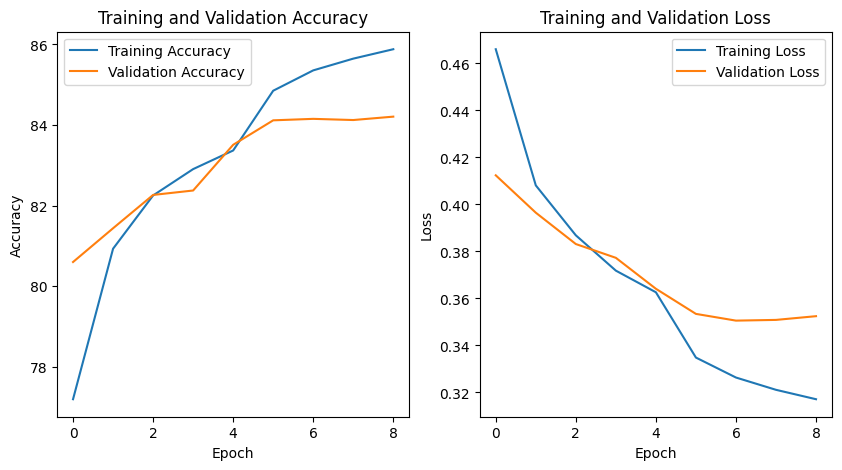

In [22]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
def evaluate_model(model, dataloader, device):
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []
    all_probs = []  # To store probabilities for ROC curve computation

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = outputs.squeeze()  # Assuming the model outputs probabilities for positive class
            predictions = (probabilities > 0.5).float()  # Convert probabilities to 0 or 1 based on threshold

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    # Convert list to numpy arrays for metric calculations
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Calculate standard metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Generate and print the classification report
    report = classification_report(all_labels, all_predictions, zero_division=0)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Print the overall metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", report)

    return accuracy, precision, recall, f1, report, conf_matrix, fpr, tpr, roc_auc

In [24]:
model_eval = SimpleBiLSTM(embedding_dim=300, hidden_dim=128, num_layers=2, batch_first=True, bidirectional=True)

# Load the state dictionary
model_eval.load_state_dict(torch.load('BiLSTM_translate.pth'))

accuracy, precision, recall, f1, report, conf_matrix, fpr, tpr, roc_auc = evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 123/123 [00:01<00:00, 78.67it/s]

Accuracy: 0.8556
Precision: 0.8264
Recall: 0.8434
F1 Score: 0.8348

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      4463
         1.0       0.83      0.84      0.83      3403

    accuracy                           0.86      7866
   macro avg       0.85      0.85      0.85      7866
weighted avg       0.86      0.86      0.86      7866



# Confusion Matrix

In [25]:
def plot_confusion_matrix(conf_matrix, class_labels):
    """
    Plots a confusion matrix using seaborn's heatmap with percentages and TP, TN, FP, FN annotations.
    """
    # Calculate the percentage of each confusion entry
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Create annotations that include both count and percentage, and classification (TP, TN, FP, FN)
    annotations = np.empty_like(conf_matrix).astype(str)
    nrows, ncols = conf_matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            c = conf_matrix[i, j]
            p = conf_matrix_percent[i, j] * 100
            if i == 0 and j == 0:
                label = "TN"
            elif i == 0 and j == 1:
                label = "FP"
            elif i == 1 and j == 0:
                label = "FN"
            elif i == 1 and j == 1:
                label = "TP"
            annotations[i, j] = f"{label}\n{c}\n({p:.1f}%)"

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=annotations, fmt='', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

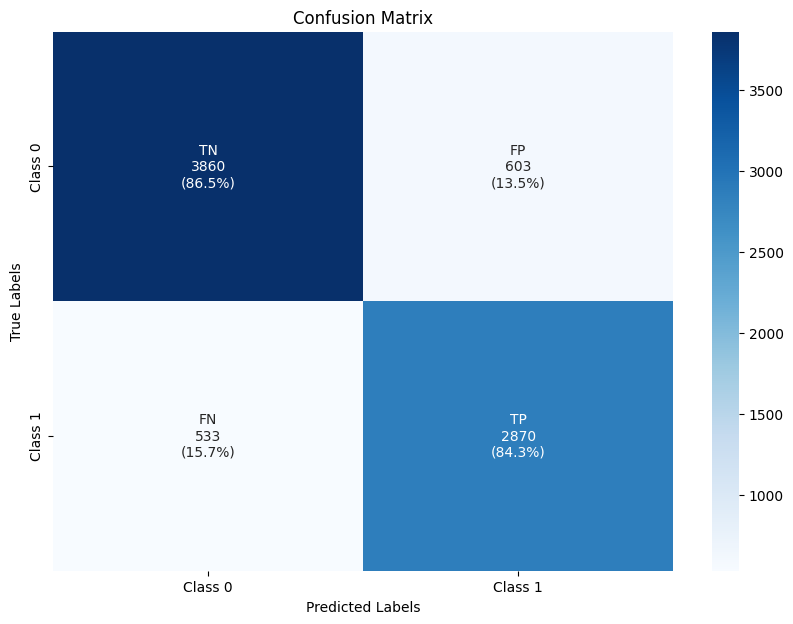

In [26]:
plot_confusion_matrix(conf_matrix, class_labels=['Class 0', 'Class 1'])

# ROC Curve

In [27]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

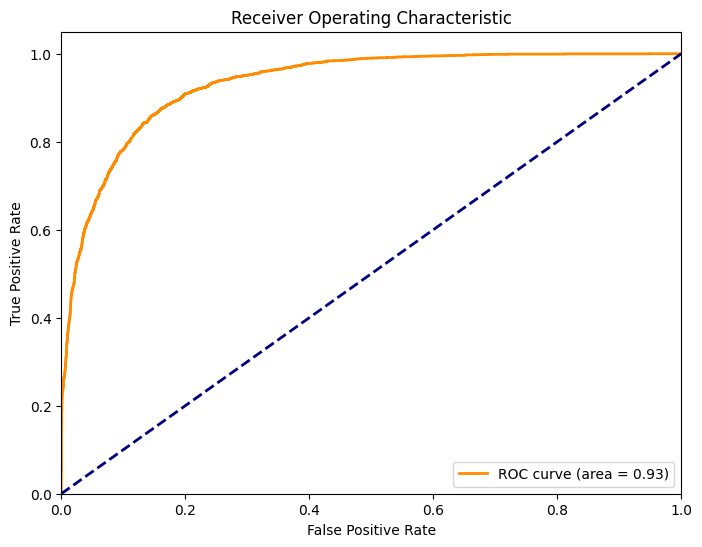

In [28]:
plot_roc_curve(fpr, tpr, roc_auc)

In [29]:
# import pickle
# pickle.dump(model, open('BiLSTM_model.pkl', 'wb'))